In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import os

In [17]:
csv_names = [f for f in os.listdir("results") if os.path.isfile(os.path.join("results", f)) and f.endswith(".csv")]
files = [os.path.join("results", f) for f in csv_names]

csv_names

['ratatui.csv',
 'actix-web.csv',
 'regex.csv',
 'async_std.csv',
 'axum.csv',
 'syn.csv',
 'tokio.csv',
 'bevy_ecs.csv',
 'serde_json.csv',
 'egui.csv',
 'clap.csv']

In [23]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df["published_at"] = pd.to_datetime(df["published_at"], unit="s")
df.head()

,name,version,published_at,edition,reported_msrv,version_signature,unsafe_exprs,total_exprs,unsafe_fraction,clippy_warnings,clippy_warnings_per_expr,async_fns,total_fns,async_fraction
0,ratatui,0.25.0,2023-12-18 12:10:49,2,70.0,20.254564,29,46525,0.000623,0,0.000000,0,1521,0.0
1,ratatui,0.24.0,2023-10-23 11:46:55,2,67.0,20.225876,29,45263,0.000641,0,0.000000,0,1404,0.0
2,ratatui,0.23.0,2023-08-28 11:51:47,2,67.0,20.212593,29,44798,0.000647,0,0.000000,0,1375,0.0
3,ratatui,0.22.0,2023-07-17 10:58:47,2,65.0,15.928348,29,40558,0.000715,0,0.000000,0,1045,0.0
4,ratatui,0.21.0,2023-05-29 10:54:16,2,65.0,16.113750,33,38164,0.000865,1,0.000026,0,760,0.0


In [35]:
metrics = ["edition", "reported_msrv", "version_signature", "unsafe_fraction", "clippy_warnings_per_expr", "async_fraction"]

def show_metric(metric, label, no_all_zero=False):
    fig, ax = plt.subplots()

    for name in df["name"].unique():
        subset = df[df["name"] == name]

        if len(subset[pd.notna(subset[metric])]) == 0:
            continue

        if no_all_zero and len(subset[subset[metric] != 0]) == 0:
            continue

        ax.plot(subset["published_at"], subset[metric], label=name, marker='.')

    # Combine all data for linear regression analysis
    all_data = df[pd.notna(df[metric])].groupby("published_at")[metric].mean().reset_index()
    x = pd.to_numeric(all_data["published_at"]).values.reshape(-1, 1)
    y = all_data[metric].values.reshape(-1, 1)

    # Linear regression analysis
    model = LinearRegression()
    model.fit(x, y)
    trend_line = model.predict(x)

    # Plot trend line
    ax.plot(all_data["published_at"], trend_line, linestyle='--', color='black', alpha=0.5, label='Overall Trend')

    plt.title(f"{label} over time")
    plt.xlabel("Date")
    plt.ylabel(label)
    plt.legend()
    fig.autofmt_xdate()
    plt.show()

    # Print trend information
    print(f"Slope: {model.coef_[0][0]} ({'Upwards' if model.coef_[0][0] > 0 else 'Downwards'})")


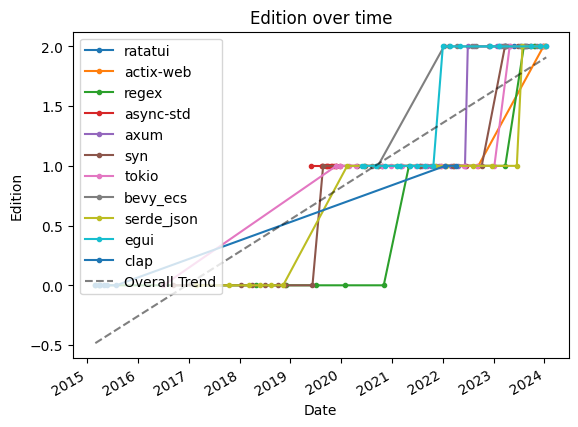

Slope: 8.544950422504213e-18 (Upwards)


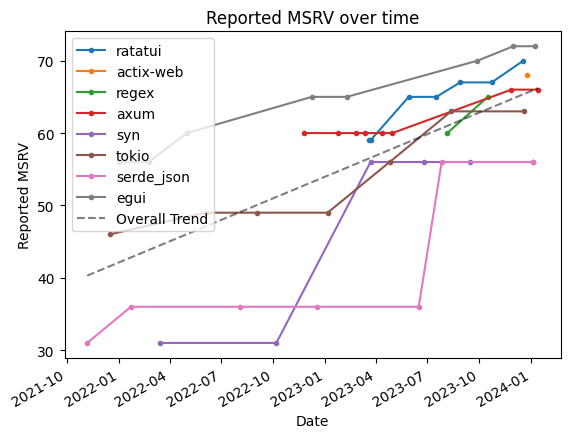

Slope: 3.7545340111152296e-16 (Upwards)


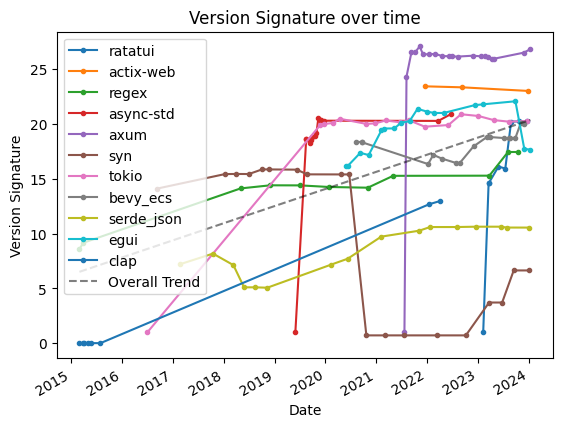

Slope: 4.949211520290693e-17 (Upwards)


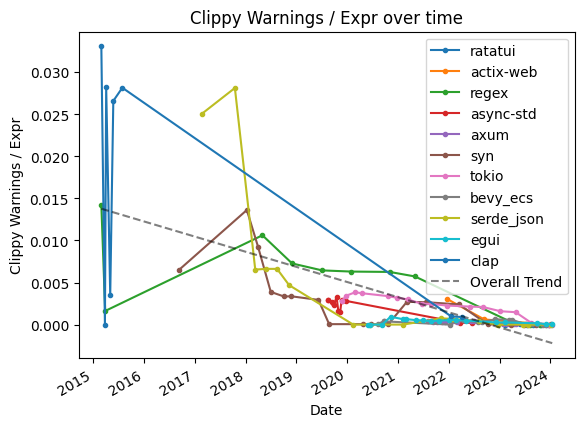

Slope: -5.706032512930683e-20 (Downwards)


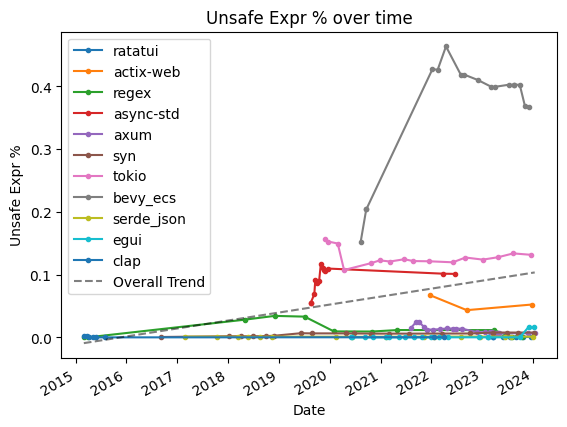

Slope: 4.0232119087789867e-19 (Upwards)


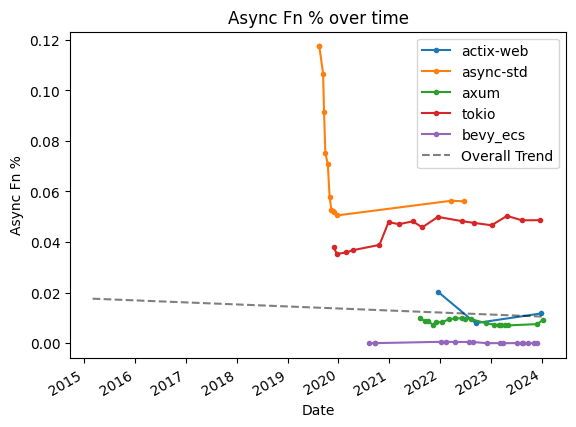

Slope: -2.536915779620348e-20 (Downwards)


In [36]:
show_metric("edition", "Edition")
show_metric("reported_msrv", "Reported MSRV")
show_metric("version_signature", "Version Signature")
show_metric("clippy_warnings_per_expr", "Clippy Warnings / Expr")
show_metric("unsafe_fraction", "Unsafe Expr %", no_all_zero=True)
show_metric("async_fraction", "Async Fn %", no_all_zero=True)